In [7]:
#http://eric.univ-lyon2.fr/~ricco/cours/slides/PJ%20-%20machine%20learning%20avec%20scikit-learn.pdf
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [8]:
import numpy
import pandas
pima = pandas.read_table("pima.txt", sep="\t", header=0)
print(pima.shape)
print(pima.columns)
print(pima.dtypes)

(768, 9)
Index(['pregnant', 'diastolic', 'triceps', 'bodymass', 'pedigree', 'age',
       'plasma', 'serum', 'diabete'],
      dtype='object')
pregnant       int64
diastolic      int64
triceps        int64
bodymass     float64
pedigree     float64
age            int64
plasma         int64
serum          int64
diabete       object
dtype: object


In [9]:
data = pima.values
X = data[:,0:8]
y = data[:,8]

from sklearn import model_selection
X_app, X_test, y_app, y_test = model_selection.train_test_split(X, y, test_size = 300, random_state=0)
print(X_app.shape, X_test.shape, y_app.shape, y_test.shape)

(468, 8) (300, 8) (468,) (300,)


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

modele = lr.fit(X_app, y_app)

print(modele.coef_, modele.intercept_)

[[ 8.75153769e-02 -1.59511103e-02  1.70428483e-03  5.18609374e-02
   5.34696503e-01  1.24335202e-02  2.40115458e-02 -2.91586161e-04]] [-5.13527961]


In [11]:
y_pred = modele.predict(X_test)

from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred)
print("ligne = observé et colonne = prédiction :\n" + str(cm))

acc = metrics.accuracy_score(y_test, y_pred)
print("acc = " + str(acc))

err = 1.0 - acc
print("err rate = " + str(err))

sensibility = metrics.recall_score(y_test, y_pred, pos_label='positive')
print(sensibility)

ligne = observé et colonne = prédiction :
[[184  17]
 [ 45  54]]
acc = 0.7933333333333333
err rate = 0.20666666666666667
0.5454545454545454


In [19]:
def specificity(y, y_hat):
    mc = metrics.confusion_matrix(y, y_hat)
    res = mc[0,0]/numpy.sum(mc[0,:])
    return res
    
specificite = metrics.make_scorer(specificity, greater_is_better = True)

sp = specificite(modele, X_test, y_test)
print(sp)

0.9154228855721394


In [20]:
lr = LogisticRegression()
modele_all = lr.fit(X, y)

print(modele_all.coef_, modele_all.intercept_)

[[ 1.17087631e-01 -1.68947770e-02  7.46053001e-04  5.97221654e-02
   6.81392866e-01  7.21999666e-03  2.83788475e-02 -6.42978367e-04]] [-5.88988049]


In [21]:
#évaluation en validation croisée : 10 cross-validation
succes = model_selection.cross_val_score(lr, X, y, cv=10, scoring='accuracy')
print(succes)
print(succes.mean())

[0.74025974 0.75324675 0.79220779 0.72727273 0.74025974 0.74025974
 0.81818182 0.79220779 0.73684211 0.82894737]
0.7669685577580314


In [22]:
modele = lr.fit(X_app, y_app)
# probabilité negative et positive pour chaque ligne
probas = lr.predict_proba(X_test)
# score probabilité que positive
score = probas[:, 1]
# transforme les valeurs y_test en 0/1
pos = pandas.get_dummies(y_test).as_matrix()
pos = pos[:, 1]

npos=numpy.sum(pos)
print("Il y a " + str(npos) + " indices 'positifs' dans l'échantillon test")

Il y a 99 indices 'positifs' dans l'échantillon test


In [33]:
index = numpy.argsort(score)
index = index[::-1]
sort_pos = pos[index]
cpos = numpy.cumsum(sort_pos)
rappel = cpos/npos
n = y_test.shape[0]
taille = numpy.arange(start=1, stop=301, step=1)
taille = taille/n

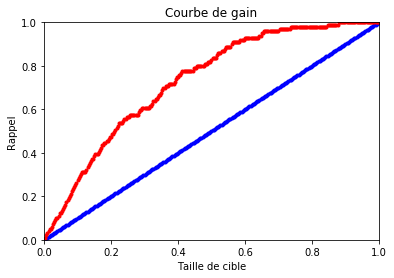

In [35]:
import matplotlib.pyplot as plt

plt.title('Courbe de gain')
plt.xlabel('Taille de cible')
plt.ylabel('Rappel')

plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(taille, taille, marker='.', color = 'blue')
plt.scatter(taille, rappel, marker='.', color = 'red')

plt.show()

In [36]:
from sklearn import svm

mvs = svm.SVC()
modele2 = mvs.fit(X_app, y_app)
y_pred2 = modele2.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred2))
print(metrics.accuracy_score(y_test, y_pred2))

[[201   0]
 [ 99   0]]
0.67


In [ ]:
from sklearn import model_selection

parameters = [{'C' : [0.1, 1, 10], 'kernel' : ['rbf', 'linear']}]
grid = model_selection.GridSearchCV(estimator=mvs, param_grid=parameters, scoring='accuracy')
grille = grid.fit(X_app, y_app)

print(pandas.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])
print(grille.best_params_)
print(grille.best_score)

y_pred3 = grille.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred3))

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

lr = LogisticRegression()
selecteur = RFE(estimator=lr)
sol = selecteur.fit(X_app, y_app)
print(sol.n_features_)
print(sol.support_)
print(sol.ranking_)

4
[ True False False  True  True False  True False]
[1 2 4 1 1 3 1 5]


In [40]:
X_new_app = X_app[:, sol.support_]
print(X_new_app.shape)

modele_sel = lr.fit(X_new_app, y_app)
X_new_test = X_test[:,sol.support_]
print(X_new_test.shape)

y_pred_sel = modele_sel.predict(X_new_test)
print(metrics.accuracy_score(y_test, y_pred_sel))

(468, 4)
(300, 4)
0.7866666666666666
